# Example #1
---
### Building a basic mesh using a single DEM tile.
---

### Step 1: Bootstrap the relevant data to the workspace

Create data directory where we will stage all the relevant data.

In [1]:
import pathlib
data_dir = pathlib.Path('data')
data_dir.mkdir(exist_ok=True)

Bootstrap the DEM tile to be meshed.
On this case, we're using a publicly available DEM from "Digital Elevation Models of Puerto Rico:
Procedures, Data Sources and Analysis" by Taylor, et al. 2007.

In [2]:
PR_dem = data_dir / 'PR_1s.tif'

if not PR_dem.exists():
    
    PR_tarfile = data_dir / 'PR_1s.tar.gz'

    import urllib.request

    with urllib.request.urlopen("https://www.dropbox.com/s/0duc0tnp43rjgrt/PR_1s.tar.gz?dl=1") as u:
        with open(PR_tarfile, "wb") as f :
            f.write(u.read())
        
    import tarfile
    
    with tarfile.open(f'{PR_tarfile}', "r:gz") as so:
        so.extractall(path=data_dir)
        
    PR_tarfile.unlink()

### Step 2: Create a "raster" object to read the DEM.

In [3]:
from geomesh import Raster
raster = Raster(PR_dem)

Let's make a plot of the raster, so that we can get familiar with the bathymetry.

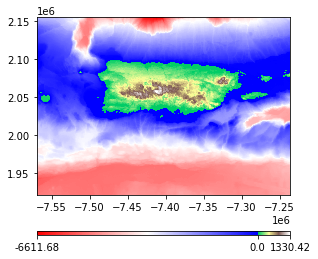

<AxesSubplot:>

In [4]:
%matplotlib inline
raster.contourf(show=True)

The size of this raster (in pixels) is:

In [5]:
raster.shape

(7200, 10800)

And the raster data resolution is:

In [6]:
raster.dx, raster.dy

(30.922081027777814, 32.515373916666626)

Note that the resolution values above are given in the raster's native coordinate reference system.
In the case of the current raster, this is:

In [7]:
raster.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

So the raster is in Mercator Projection, that means that the dx and dy values provided above above are given in meter units.

### Step 3: Create a "geom" object using the raster.
This "geom" object will represent the outer and inner boundaries of the target mesh.

In [8]:
from geomesh import Geom
geom = Geom(raster, zmax=20.)

The zmax argument can be used to generate the mesh boundaries to no exceed the 20 meter elevation contour level. Note that this zmax value must be consistent with the vertical datum units of the input DEM.

Let's make a plot of this geom.

<AxesSubplot:>

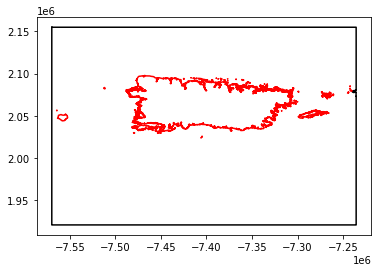

In [9]:
geom.make_plot()

The black line represents the outer boundary of the mesh, while the red lines represent the inner boundaries of the target mesh. The inner boundaries reach a height of 20 meters, based on the DEM data provided.

### Step 3: Create a "hfun" object using the raster.
We will use this "hfun" instance to create size constraints for the final mesh.

In [10]:
from geomesh import Hfun
hfun = Hfun(raster, hmin=50., hmax=15000, verbosity=1)

Note: The size function (hfun) is initialized with hmin and hmax parameters, which are always given in meters, regardless of the coordinate reference system of the underlying DEM. These hmin and hmax represen the global minimum and maximum element sizes that the final mesh may have. These parameters are optonal. The hfun is initialized using the maximum value, if provided.

Let's add the classic linear distance from the shoreline constraint. The required arguments are the target contour level, and the expasion rate. The nprocs parameter can be used to dramatically speed-up computation.

In [11]:
%%time
from multiprocessing import cpu_count
hfun.add_contour(0., 0.01, nprocs=cpu_count())

CPU times: user 1min 57s, sys: 2.42 s, total: 2min
Wall time: 23.6 s


We can see a plot of the resulting size function:

CPU times: user 14 s, sys: 329 ms, total: 14.3 s
Wall time: 14.3 s


(-7569740.835, -7235782.3599, 1920808.8729, 2154919.5651)

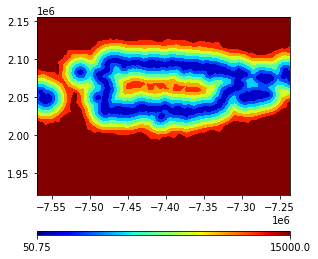

In [12]:
%%time
ax = hfun.tricontourf(cmap='jet')
ax.axis('scaled')

We can also look at the preliminary unstructured mesh formed with the current constraints.

CPU times: user 357 ms, sys: 41 µs, total: 357 ms
Wall time: 357 ms


(-7586438.758755, -7219084.436144999, 1909103.33829, 2166625.0997099997)

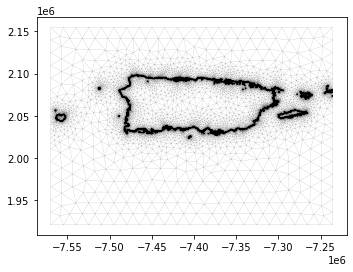

In [13]:
%%time
ax = hfun.triplot()
ax.axis('scaled')

As long as the constraints in hfun don't change, the cached mesh will be resused. However, can add further constraints and replot of the resulting size function.

CPU times: user 46.1 s, sys: 2.73 s, total: 48.8 s
Wall time: 51.4 s


(-7586438.758755, -7219084.436144999, 1909103.33829, 2166625.0997099997)

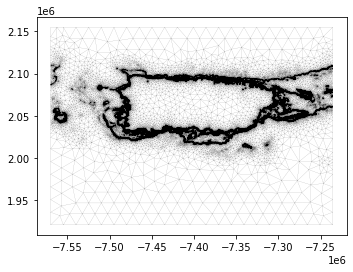

In [14]:
%%time
hfun.add_subtidal_flow_limiter(upper_bound=0., lower_bound=-1500.)
ax = hfun.triplot()
ax.axis('scaled')

Notice how in contrast to the previous example, on this one the shelf break and areas of high gradients are now part of the tesselation.

### Step 4: Combine the geom and hfun using the JigsawDriver

In [15]:
%%time
from geomesh import JigsawDriver
driver = JigsawDriver(geom, hfun, verbosity=1)
mesh = driver.run()

CPU times: user 2min 32s, sys: 1.27 s, total: 2min 33s
Wall time: 2min 33s


### Step 5: Interpolate raster to the mesh

In [16]:
%%time
mesh.interpolate(raster)

CPU times: user 30.8 ms, sys: 289 ms, total: 320 ms
Wall time: 6.33 s


Plot the bathymetry:

(-7569740.835, -7235782.3599, 1920808.8729, 2154919.5651)

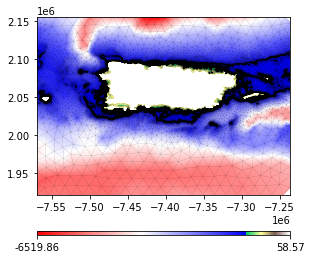

In [17]:
ax = mesh.tricontourf(cmap='topobathy')
mesh.triplot(axes=ax)
ax.axis('scaled')

### ~~Step 6: Generate mesh boundaries~~
Coming soon.

### Step 7: Save output file to disk

In [ ]:
mesh.write(data_dir / 'example_1.2dm', format='2dm', overwrite=True)

In [ ]:
with open(data_dir / 'example_1.2dm') as f:
    for i in range(6):
        print(f.readline(), end='')